# Generic cell clustering notebook

In [1]:
# import required packages
import json
import os
import subprocess
from datetime import datetime as dt
import sys

import feather
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr
from matplotlib import rc_file_defaults
from alpineer import io_utils, load_utils, misc_utils

from ark.analysis import visualize
from ark.phenotyping import cell_cluster_utils, cell_som_clustering, cell_meta_clustering
from ark.utils import data_utils, example_dataset, plot_utils
from ark.utils.metacluster_remap_gui import (MetaClusterData, MetaClusterGui,
                                             colormap_helper,
                                             metaclusterdata_from_files)
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## 0: Set root directory and download the example dataset

Here we are using the example data located in `/data/example_dataset/input_data`. To modify this notebook to run using your own data, simply change `base_dir` to point to your own sub-directory within the data folder, rather than `'example_dataset'`. 

* `base_dir`: the path to all of your imaging data. Should contain a directory for your images, segmentations, and cell table (generated from `1_Nimbus_Predict.ipynb`). This directory will also store all of the directories/files created during pixel clustering.

In [2]:
# define the home directory containing pixel_output_dir
base_dir = "../data/example_dataset"

## 1: Set input paths

Define the following paths:

- `tiff_dir`: the path to the directory with extracted image data
- `cell_table_path`: the path to the cell table generated by `1_Nimbus_Predict.ipynb`

In [3]:
tiff_dir = os.path.join(base_dir, 'image_data')
cell_table_path = os.path.join(base_dir, 'nimbus_output', 'nimbus_cell_table.csv')

# load cell table
cell_table = pd.read_csv(cell_table_path)

Define the list of FOVs and expression columns to use for cell SOM clustering

In [4]:
# explicitly set the SOM expression columns here

cell_som_cluster_cols = [
       'CD14_pred', 'CD163_pred', 'CD20_pred',
       'CD3_pred', 'CD31_pred', 'CD4_pred', 'CD45_pred', 'CD68_pred',
       'CD8_pred', 'CK17_pred', 'Collagen1_pred', 'ECAD_pred',
       'Fibronectin_pred', 'GLUT1_pred', 'HLADR_pred', 'IDO_pred', 'Ki67_pred',
       'PD1_pred', 'SMA_pred', 'Vim_pred'
]

# verify that the columns provided exist in cell_table
misc_utils.verify_in_list(
    provided_cell_cols=cell_som_cluster_cols,
    cell_som_input_cols=cell_table.columns.values
)

# extract the set of FOVs used in the dataset
fovs = list(cell_table['fov'].unique())

Set a prefix to be applied to all data directories/files created by pixel and cell clustering. If the prefix is not set, a default of the datetime at the start of the run is used.

In [5]:
# explicitly set cell_cluster_prefix to override datetime default
cell_cluster_prefix = "example"

if cell_cluster_prefix is None:
    cell_cluster_prefix = dt.now().strftime('%Y-%m-%dT%H:%M:%S')

The following folders/files will be created with names prefixed by `cell_cluster_prefix`:

* `cell_output_dir`: the name of the folder to store the cell clustering directories/files
* `cell_som_weights_name`: file name to place the cell SOM weights
* `cell_som_expr_col_avg_name`: file name to store the average expression values of each `cell_som_cluster_cols` per cell SOM cluster
* `cell_meta_expr_col_avg_name`: same as above except for cell meta clusters
* `cell_meta_cluster_remap_name`: for the meta cluster remapping process, the file to store the new SOM to meta mappings

In [6]:
# define the base output cell folder
cell_output_dir = '%s_cell_output_dir_generic' % cell_cluster_prefix
if not os.path.exists(os.path.join(base_dir, "pixie", cell_output_dir)):
    os.makedirs(os.path.normpath(os.path.join(base_dir, "pixie", cell_output_dir)))
    
# define the paths to cell clustering files, explicitly set the variables to use custom names
cell_som_weights_name = os.path.join("pixie", cell_output_dir, 'cell_som_weights.feather')
cell_som_expr_col_avg_name = os.path.join("pixie", cell_output_dir, 'cell_som_expr_col_avg.csv')
cell_meta_expr_col_avg_name = os.path.join("pixie", cell_output_dir, 'cell_meta_expr_col_avg.csv')
cell_meta_cluster_remap_name = os.path.join("pixie", cell_output_dir, 'cell_meta_cluster_mapping.csv')

## 2: Cell clustering

### 2.1: train cell SOM

Train the cell SOM on the expression values provided per cell (the data stored in `cell_som_input_name`).  Training is done using the `FlowSOM` algorithm. Note that each of the `cell_som_cluster_cols` are normalized by their 99.9% value prior to training.

For a full set of parameters you can customize for `train_cell_som`, please consult: <a href=https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.phenotyping.html#ark.phenotyping.cell_cluster_utils.train_cell_som>cell training docs</a>.

In [7]:
# create the cell-level SOM weights
cell_pysom = cell_som_clustering.train_cell_som(
    fovs,
    base_dir,
    cell_table_path,
    cell_som_cluster_cols,
    cell_table,
    som_weights_name=cell_som_weights_name,
    num_passes=10,
    overwrite=True,
    xdim=20,
    ydim=20,
)

Training SOM


E:\angelo_lab\ark-analysis\src\ark\phenotyping\cluster_helpers.py:359: UserWarning: Overwrite flag set, retraining SOM
  warnings.warn('Overwrite flag set, retraining SOM')


### 2.2: assign cell SOM clusters

Use the weights learned from `train_cell_som` to assign cell clusters to the cell dataset. As with `train_pixel_som`, each of the columns are normalized by their 99.9% value prior to assigning a cell SOM cluster label.

`generate_som_avg_files` will then compute the average values of all columns in `cell_som_cluster_cols` per cell SOM cluster as well as the number of cells in each cell SOM cluster (the data placed in `cell_som_expr_col_avg_name`). This is needed for cell consensus clustering.

In [8]:
# use cell SOM weights to assign cell clusters
cell_table = cell_som_clustering.cluster_cells(
    base_dir,
    cell_pysom,
    cell_som_cluster_cols=cell_som_cluster_cols
)

# generate the SOM cluster summary files
cell_som_clustering.generate_som_avg_files(
    base_dir,
    cell_table,
    cell_som_cluster_cols=cell_som_cluster_cols,
    cell_som_expr_col_avg_name=cell_som_expr_col_avg_name
)

SOM clusters already assigned to each cell
Already generated average expression file for each cell SOM column, skipping


### 2.3: run cell consensus clustering

With the SOM cluster labels assigned to the cell data, assign consensus cluster labels. The consensus clusters are trained on the average values of all columns in `cell_som_cluster_cols` per cell SOM cluster (the data stored in `cell_som_expr_col_avg_name`). These values are z-scored and capped at the value specified in the `cap` argument prior to training: this helps improve the meta clustering process.

After consensus clustering, the following are also computed by `generate_meta_avg_files`:

* The average values of all columns in `cell_som_cluster_cols` per cell meta cluster, and the number of cells per meta cluster (the data placed in `cell_meta_expr_col_avg_name`)
* The meta cluster mapping for each cell SOM cluster in `cell_som_expr_col_avg_name` (data is resaved, same data except with an associated meta cluster column)

For a full set of parameters you can customize for `cell_consensus_cluster`, please consult: <a href=https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.phenotyping.html#ark.phenotyping.cell_cluster_utils.cell_consensus_cluster>cell consensus clustering docs</a>. Do note that weighted cell channel computations are unsupported as it is outside the scope of generic cell clustering.

* `max_k`: the number of consensus clusters desired
* `cap`: used to clip z-scored values prior to consensus clustering (in the range `[-cap, cap]`)

In [9]:
max_k = 20
cap = 3

# run hierarchical clustering based on cell SOM cluster assignments
cell_cc, cell_table = cell_meta_clustering.cell_consensus_cluster(
    base_dir,
    cell_som_cluster_cols=cell_som_cluster_cols,
    cell_som_input_data=cell_table,
    cell_som_expr_col_avg_name=cell_som_expr_col_avg_name,
    max_k=max_k,
    cap=cap,
)

# generate the meta cluster summary files
cell_meta_clustering.generate_meta_avg_files(
    base_dir,
    cell_cc,
    cell_som_cluster_cols=cell_som_cluster_cols,
    cell_som_input_data=cell_table,
    cell_som_expr_col_avg_name=cell_som_expr_col_avg_name,
    cell_meta_expr_col_avg_name=cell_meta_expr_col_avg_name
)

Meta clusters already assigned to each cell
Already generated average expression file for cell meta clusters, skipping


## 3: visualize results

### 3.1: use the interactive reclustering results to relabel cell meta clusters

The visualization shows the z-scored average `cell_som_cluster_cols` expression per cell SOM and meta cluster. The heatmaps are faceted by cell SOM clusters on the left and cell meta clusters on the right.

## Usage

### Quickstart
- **Select**: Left Click
- **Remap**: **New metacluster button** or Right Click
- **Edit Metacluster Name**: Textbox at bottom right of the heatmaps.

### Selection and Remapping details
- To select a SOM cluster, click on its respective position in the **selected** bar. Click on it again to deselect.
- To select a meta cluster, click on its corresponding color in the **metacluster** bar. Click on it again to deselect.
- To remap the selected clusters, click the **New metacluster** button (alternatively, right click anywhere). Note that remapping an entire metacluster deletes it.
- To clear the selected SOM/meta clusters, use the **Clear Selection** button.
- **After remapping a meta cluster, make sure to deselect the newly created one to prevent unwanted combinations.**

### Other features and notes
- You will likely need to zoom out to see the entire visualization. To toggle Zoom, use Ctrl -/Ctrl + on Windows or ⌘ +/⌘ - on Mac.
- The bars at the top show the number of cells in each SOM cluster.
- The text box at the bottom right allows you to rename a particular meta cluster. This can be useful as remapping may cause inconsistent numbering.
- Adjust the z-score limit using the slider on the bottom left to adjust your dynamic range.
- When meta clusters are combined or a meta cluster is renamed, the change is immediately saved to `cell_meta_cluster_remap_name`.
- You won't be able to advance until you've clicked `New metacluster` or renamed a meta cluster at least once. If you do not want to make changes, just click `New metacluster` to trigger a save before continuing.

In [10]:
%matplotlib widget
rc_file_defaults()
plt.ion()

cell_mcd = metaclusterdata_from_files(
    os.path.join(base_dir, cell_som_expr_col_avg_name),
    cluster_type='cell'
)
cell_mcd.output_mapping_filename = os.path.join(base_dir, cell_meta_cluster_remap_name)
cell_mcg = MetaClusterGui(cell_mcd, width=17)

Relabel the cell meta clusters using the mapping.

In [11]:
# rename the meta cluster values in the cell dataset
cell_table = cell_meta_clustering.apply_cell_meta_cluster_remapping(
    base_dir,
    cell_table,
    cell_meta_cluster_remap_name
)

# recompute the mean column expression per meta cluster and apply these new names to the SOM cluster average data
cell_meta_clustering.generate_remap_avg_count_files(
    base_dir,
    cell_table,
    cell_meta_cluster_remap_name,
    cell_som_cluster_cols,
    cell_som_expr_col_avg_name,
    cell_meta_expr_col_avg_name,
)

Using re-mapping scheme to re-label cell meta clusters
Re-compute average value of each training column specified per cell meta cluster
Re-assigning meta cluster column in cell SOM cluster average pixel cluster counts data


Generate the color scheme returned by the interactive reclustering process. This will be for visualizing the weighted channel average heatmaps and the cell cluster overlay.

In [12]:
raw_cmap, renamed_cmap = colormap_helper.generate_meta_cluster_colormap_dict(
    cell_mcd.output_mapping_filename,
    cell_mcg.im_cl.cmap,
    cluster_type='cell'
)

### 3.2: cell cluster overlay (cell meta clusters only)

This will take your FOVs and generate cell cluster images in batches. Run this cell if you wish to create a significant amount of cell cluster mask images for downstream analysis.

Generating overlays will require you to define the following:

- `segmentation_dir`: the path to the directory with Mesmer segmented images
- `seg_suffix`: the suffix used for the files in `segmentation_dir`
- `subset_cell_fovs`: the list of FOVs you want to visualize

In [13]:
segmentation_dir = os.path.join("segmentation", "deepcell_output")
seg_suffix = '_whole_cell.tiff'
subset_cell_fovs = ['fov0', 'fov1']

In [14]:
# generate and save the cell cluster masks for each fov in subset_cell_fovs
data_utils.generate_and_save_cell_cluster_masks(
    fovs=subset_cell_fovs,
    save_dir=os.path.join(base_dir, "pixie", cell_output_dir),
    seg_dir=os.path.join(base_dir, segmentation_dir),
    cell_data=cell_table,
    seg_suffix=seg_suffix,
    sub_dir='cell_masks',
    name_suffix='_cell_mask'
)

Cell Cluster Mask Generation:   0%|          | 0/2 [00:00<?, ?FOVs/s]

c:\ProgramData\Anaconda3\envs\deepcell\lib\site-packages\numba-0.56.4-py3.9-win-amd64.egg\numba\typed\typeddict.py:33: NumbaTypeSafetyWarning: unsafe cast from int64 to int32. Precision may be lost.
  d[key] = value


Load a subset of the cell cluster masks that you would like to preview.

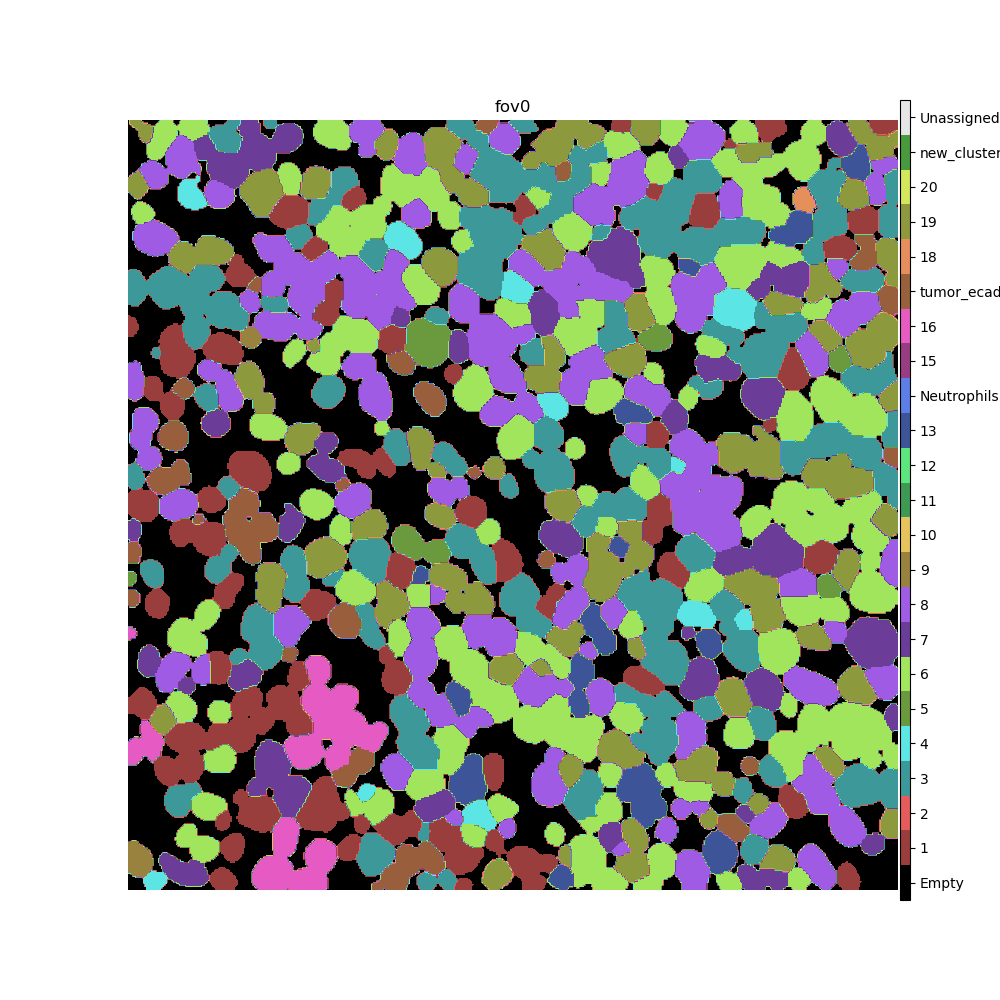

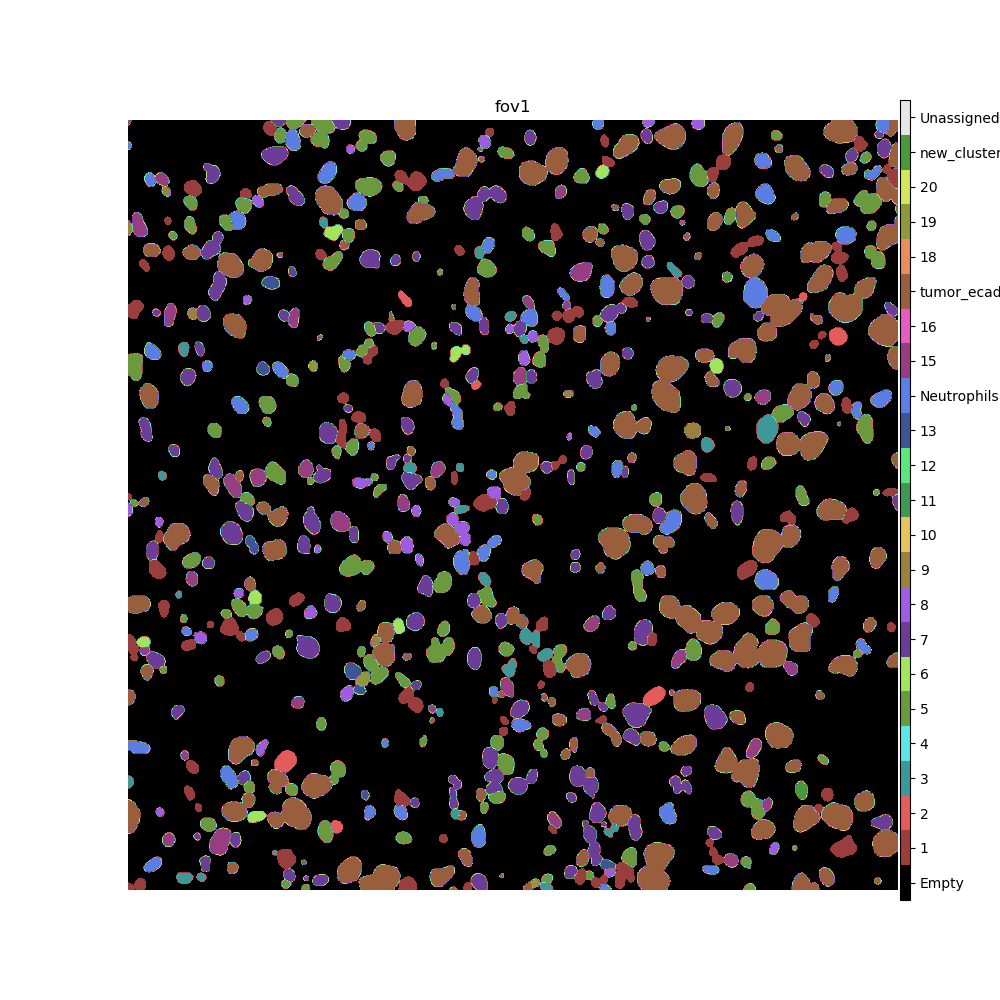

In [15]:
for cell_fov in subset_cell_fovs:
    cell_cluster_mask = load_utils.load_imgs_from_dir(
        data_dir = os.path.join(base_dir, "pixie", cell_output_dir, "cell_masks"),
        files=[cell_fov + "_cell_mask.tiff"],
        trim_suffix="_cell_mask",
        match_substring="_cell_mask",
        xr_dim_name="cell_mask",
        xr_channel_names=None,
    )

    plot_utils.plot_pixel_cell_cluster_overlay(
        cell_cluster_mask,
        [cell_fov],
        os.path.join(base_dir, cell_meta_cluster_remap_name),
        metacluster_colors=raw_cmap,
        cluster_type='cell'
    )

### 3.3: save the full results of Pixie cell clustering

`cell_table` with the SOM, meta, and renamed meta cluster labels, is resaved to `cell_table_path` as a `.csv` file.

In [16]:
cell_table.to_csv(
    cell_table_path,
    index=False
)

### 3.4: Save Images a Mantis Viewer Project

Mantis Viewer is a visualization tool for multi-dimensional imaging in pathology. Learn more about Mantis Viewer in the [README](../README.md#mantis-viewer).

In [17]:
plot_utils.create_mantis_dir(
    fovs=subset_cell_fovs,
    mantis_project_path=os.path.join(base_dir, "pixie", cell_output_dir, "mantis"),
    img_data_path=tiff_dir,
    mask_output_dir=os.path.join(base_dir, "pixie", cell_output_dir, "cell_masks"),
    mapping = os.path.join(base_dir, cell_meta_cluster_remap_name),
    seg_dir=os.path.join(base_dir, segmentation_dir),
    cluster_type='cell',
    mask_suffix="_cell_mask",
    seg_suffix_name=seg_suffix
)